### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import CjCriterion, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *

### Add parameters for limit order market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [5]:
def get_cj_env_Poisson(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = terminal_time/n_steps
    max_depth = 5
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), step_size=step_size)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
def get_cj_env_Hawkes(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    max_depth = 5
    step_size = terminal_time/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories)
    arrival_model = HawkesArrivalModel(num_trajectories=num_trajectories, step_size=step_size)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [47]:
num_trajectories = 1000
cj_env_Hawkes = get_cj_env_Hawkes(num_trajectories)
env = ReduceStateSizeWrapper(cj_env_Hawkes, [1,2,4,5])
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [8]:
cj_agent = CarteaJaimungalMmAgent(env=c, max_inventory = 10)

In [9]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging 
tensorboard_logdir = "./tensorboard/PPO-learning-Hawkes/"
best_model_path = "./SB_models/PPO-best-Hawkes"

### Define PPO policy

In [10]:
policy_kwargs = dict(net_arch=[dict(pi=[64, 64], vf=[128, 128])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "batch_size": int(n_steps * num_trajectories / 20), 
              "n_steps": int(n_steps)} #256 before (batch size)
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, 
                       eval_freq = 200,#200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)

In [11]:
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [12]:
model.learn(total_timesteps = 1_000_000)

Logging to ./tensorboard/PPO-learning-Hawkes/PPO_15
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 100        |
|    ep_rew_mean     | -1.5505817 |
| time/              |            |
|    fps             | 47618      |
|    iterations      | 1          |
|    time_elapsed    | 2          |
|    total_timesteps | 100000     |
-----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.81525683 |
| time/                   |             |
|    fps                  | 6488        |
|    iterations           | 2           |
|    time_elapsed         | 30          |
|    total_timesteps      | 200000      |
| train/                  |             |
|    approx_kl            | 0.002190533 |
|    clip_fraction        | 0.00693     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |


## Exploring the learnt policy

In [13]:
from mbt_gym.agents.SbAgent import SbAgent

In [14]:
agent = SbAgent(model)

In [48]:
inventories = np.arange(-3,4,1)
bid_actions = {}
ask_actions = {}
intensities=[5,10,20]
for intensity in intensities:
    bid_actions[intensity] = []
    ask_actions[intensity] = []
    for inventory in inventories:
        # state: inventory, time, intensity, intensity (cash /stock price removed by wrapper)
        action = np.reshape(model.predict([inventory,0.5, intensity, intensity], deterministic=True)[0], 2)    
        
        # inverse action normalisation
        action = cj_env_Hawkes.normalise_action(action, inverse=True)
        
        bid_action, ask_action = action
        
        bid_actions[intensity].append(bid_action)
        ask_actions[intensity].append(ask_action)

In [49]:
#cj_agent.get_action(np.array([[0,inventory,0.5]]))

In [50]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    # state: cash, inventory, time
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]]))[0,:].reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

## Action against intensity and inventory (time fixed at 0.5)

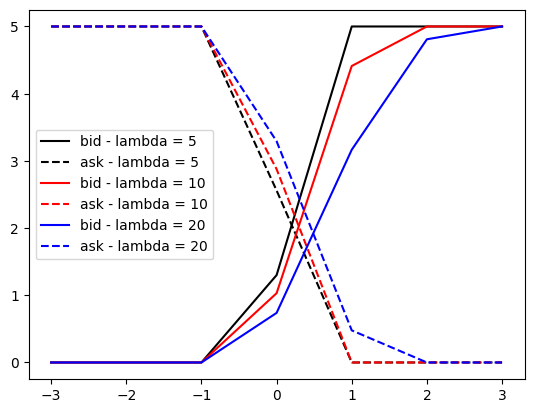

In [52]:
colors = ["k", "r", "b"]

for i, intensity in enumerate(intensities):
    plt.plot(inventories, bid_actions[intensity], label = f"bid - lambda = {intensity}", color = colors[i])
    plt.plot(inventories, ask_actions[intensity], label = f"ask - lambda = {intensity}", color = colors[i], linestyle = "--")
plt.legend()

In [20]:
timestamps = np.arange(0,1 + 0.01, 0.01)

In [55]:
bid_actions = {}
ask_actions = {}

# loop over intensities? (currently just using 10 below)
#intensities = [5,10,15,20]
intensities = [5,10,15,20]

for intensity in intensities:

    bid_actions[intensity] = {}
    ask_actions[intensity] = {}
    
    for inventory in inventories:
        bid_actions[intensity][inventory] = []
        ask_actions[intensity][inventory] = []
        for timestamp in timestamps:
            state = np.array([[inventory, timestamp, intensity, intensity]])
            bid_action, ask_action = agent.get_action(state)[0]
            bid_actions[intensity][inventory].append(bid_action)
            ask_actions[intensity][inventory].append(ask_action)

 ## Bid actions againt time/inventory (for varying intensities across plots)

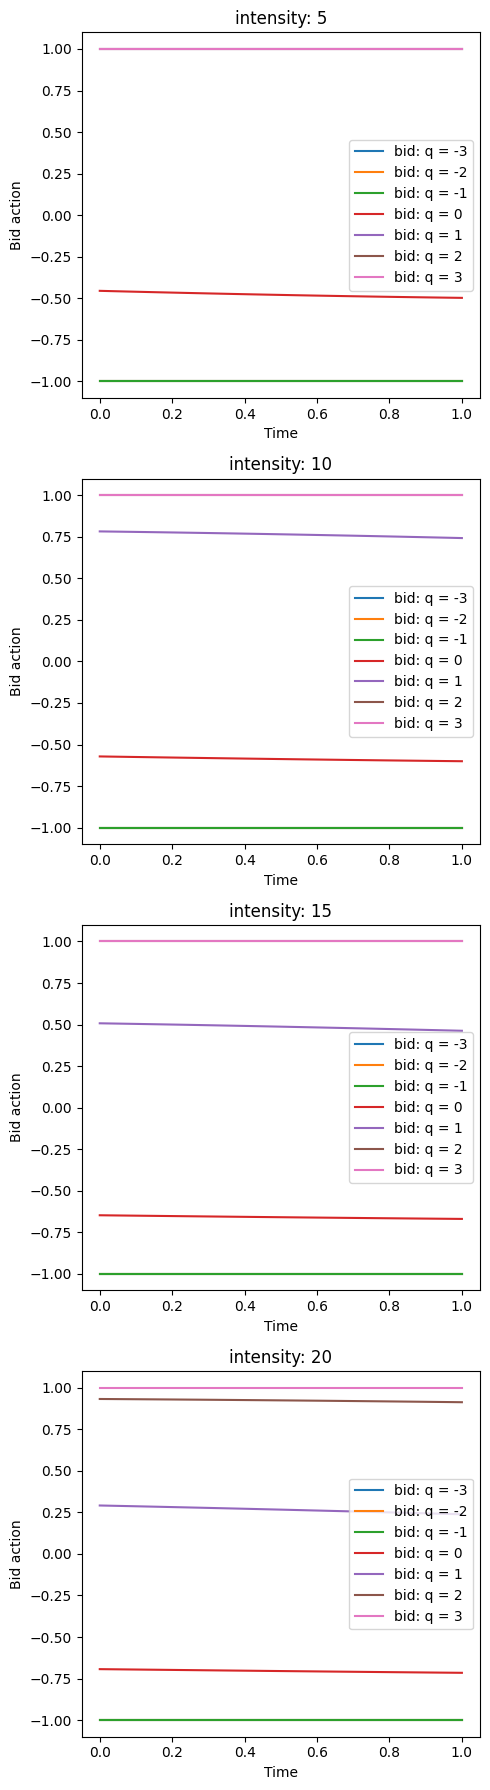

In [56]:
fig, axs = plt.subplots(len(intensities),1, figsize=(5,18))

for i,intensity in enumerate(intensities):
    
    ax = axs[i]

    for inventory in inventories:
        ax.plot(timestamps, bid_actions[intensity][inventory], label=f"bid: q = {inventory}")
        #print(bid_actions[intensity][inventory])
    ax.set_xlabel("Time")
    ax.set_ylabel("Bid action")  
    ax.set_title('intensity: %d' % intensity)
    ax.legend()
    
plt.tight_layout()

plt.show()

 ## Ask actions againt time/inventory (for varying intensities across plots)

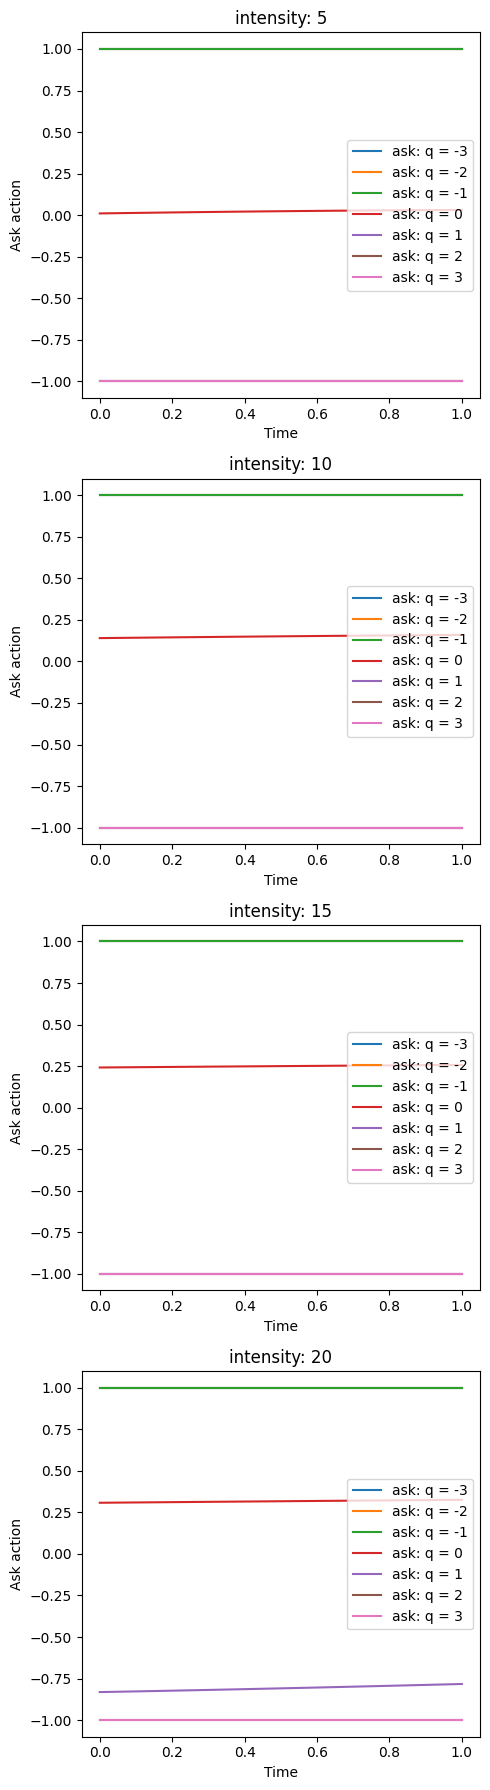

In [25]:
fig, axs = plt.subplots(len(intensities),1, figsize=(5,18))

for i,intensity in enumerate(intensities):
    
    ax = axs[i]

    for inventory in inventories:
        ax.plot(timestamps, ask_actions[intensity][inventory], label=f"ask: q = {inventory}")
        #print(bid_actions[intensity][inventory])
    ax.set_xlabel("Time")
    ax.set_ylabel("Ask action")  
    ax.set_title('intensity: %d' % intensity)
    ax.legend()
    
plt.tight_layout()

plt.show()

In [26]:
model.save("trained_model")

In [27]:
loaded = PPO.load("trained_model.zip")

In [28]:
loaded

In [57]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')